In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import VGG16

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Shape of x_train : {x_train.shape}\nShape of y_train : {y_train.shape}\nShape of x_test : {x_test.shape}\nShape of y_test : {y_test.shape}")

# Normalize the data
x_train = x_train/255.0
x_test = x_test/255.0

Shape of x_train : (60000, 28, 28)
Shape of y_train : (60000,)
Shape of x_test : (10000, 28, 28)
Shape of y_test : (10000,)


In [24]:
# expand the dimensions for x_train, x_test (28x28 -> 28x28x1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(f"Shape of x_train : {x_train.shape}\nShape of x_test : {x_test.shape}")

Shape of x_train : (60000, 28, 28, 1)
Shape of x_test : (10000, 28, 28, 1)


In [25]:
# resize the image
x_train = tf.image.resize(x_train, size=[48,48])
x_test = tf.image.resize(x_test, size=[48,48])

print(f"Shape of x_train : {x_train.shape}\nShape of x_test : {x_test.shape}")

# change the shape to (48*48*3)
x_train = tf.repeat(input=x_train, repeats=3, axis=-1)
x_test = tf.repeat(input=x_test, repeats=3, axis=-1)

print(f"Shape of x_train : {x_train.shape}\nShape of x_test : {x_test.shape}")

Shape of x_train : (60000, 48, 48, 1)
Shape of x_test : (10000, 48, 48, 1)
Shape of x_train : (60000, 48, 48, 3)
Shape of x_test : (10000, 48, 48, 3)


In [26]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
vgg_output = tf.keras.layers.Flatten()(vgg_model.layers[-1].output)

vgg_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=vgg_output)

# Freeze the layers of pre-trained model
for layer in vgg_model.layers:
    layer.trainable = False

In [27]:
# FC layer for the minst dataset
x = vgg_model.output
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

In [28]:
new_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=x)
new_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [30]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'mse'])
vgg_training = new_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, validation_split=0.2)

Epoch 1/10
1875/1875 [==============================] - 1124s 599ms/step - loss: 0.1823 - accuracy: 0.9419 - mse: 27.3837 - val_loss: 0.1246 - val_accuracy: 0.9599 - val_mse: 27.3326
Epoch 2/10
1875/1875 [==============================] - 260s 139ms/step - loss: 0.1342 - accuracy: 0.9568 - mse: 27.3871 - val_loss: 0.0990 - val_accuracy: 0.9689 - val_mse: 27.3350
Epoch 3/10
1875/1875 [==============================] - 275s 147ms/step - loss: 0.1165 - accuracy: 0.9616 - mse: 27.3883 - val_loss: 0.0987 - val_accuracy: 0.9686 - val_mse: 27.3356
Epoch 4/10
1875/1875 [==============================] - 304s 162ms/step - loss: 0.1065 - accuracy: 0.9652 - mse: 27.3889 - val_loss: 0.0897 - val_accuracy: 0.9708 - val_mse: 27.3356
Epoch 5/10
1875/1875 [==============================] - 244s 130ms/step - loss: 0.0999 - accuracy: 0.9671 - mse: 27.3895 - val_loss: 0.0789 - val_accuracy: 0.9755 - val_mse: 27.3359
Epoch 6/10
1875/1875 [==============================] - 238s 127ms/step - loss: 0.0942 - 

In [32]:
loss_value, accuracy_value, mse_value = new_model.evaluate(x_test, y_test)
print(f"Loss function value = {loss_value}\nAccuracy of the model = {accuracy_value}\nMSE value for the model = {mse_value}")

313/313 [==============================] - 34s 110ms/step - loss: 0.0698 - accuracy: 0.9773 - mse: 27.3373
Loss function value = 0.0697765052318573
Accuracy of the model = 0.9772999882698059
MSE value for the model = 27.337303161621094


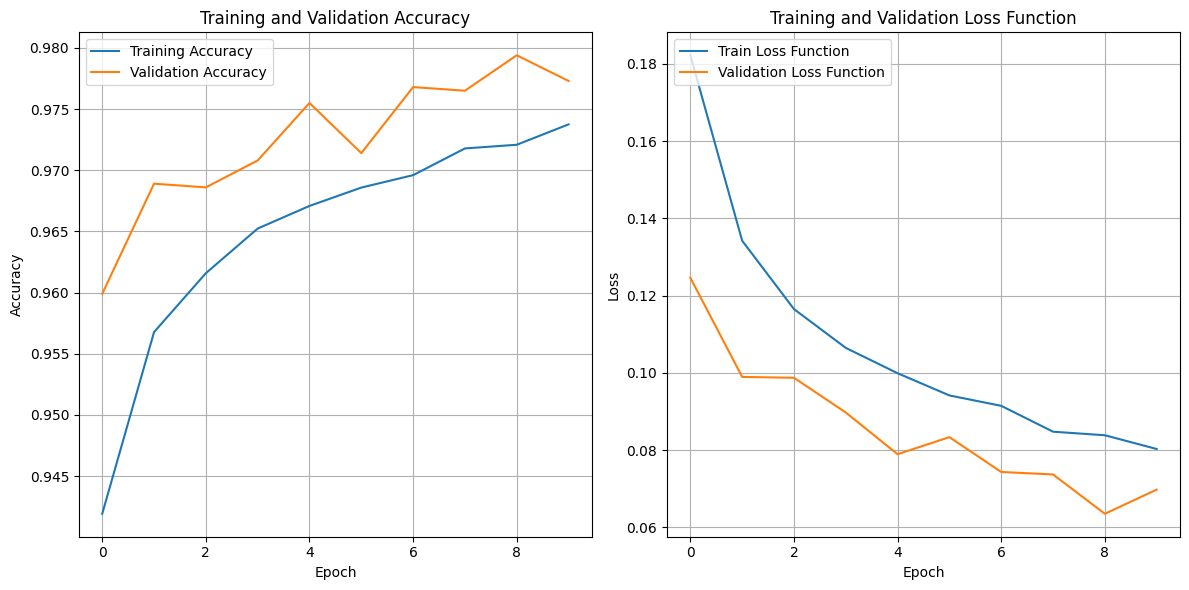

In [33]:
history = vgg_training

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['Train Loss Function', 'Validation Loss Function'], loc='upper left')

plt.tight_layout()
plt.show()

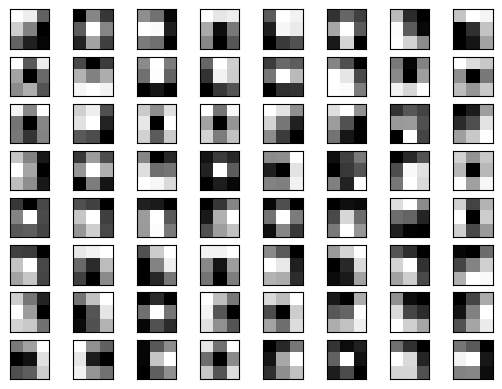

In [34]:
def model_filters(layer, x, y):
    filters, biases = layer.get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    fig, axes = plt.subplots(x, y)

    idx = 0
    for i in range(x):
        for j in range(y):
            if idx < filters.shape[3]:
                ax = axes[i, j]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(filters[:, :, 0, idx], cmap='gray')
                idx += 1
            else:
                axes[i, j].axis('off')

    plt.show()

# Choose a convolutional layer and its dimensions (x, y) for visualization
conv_layer = new_model.layers[1]  # Replace with the layer of your choice
x, y = 8, 8  # Grid size for visualization, adjust based on the number of filters

model_filters(conv_layer, x, y)

1/1 [==============================] - 0s 67ms/step


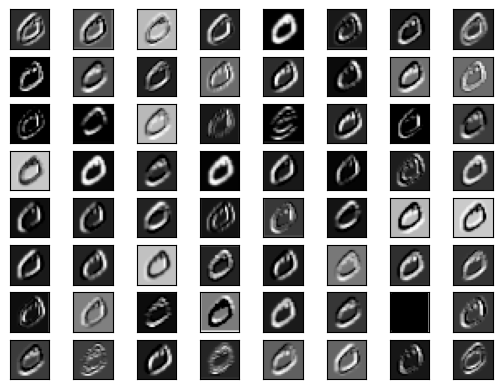

In [35]:
def model_feature_map(model, layer_name, image, n_features):
    feature_map_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
    feature_maps = feature_map_model.predict(image)

    square = int(np.sqrt(n_features))
    ix = 1
    fig, axes = plt.subplots(square, square)

    for _ in range(square):
        for _ in range(square):
            ax = axes[int((ix-1)/square), (ix-1)%square]
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1

    plt.show()

# Choose a layer, an image, and the number of features to visualize
layer_name = 'block1_pool'  # Replace with the layer of your choice
image = x_train[1:2]  # Select an image from the dataset
n_features = 64  # Adjust based on the layer

model_feature_map(new_model, layer_name, image, n_features)
